# Decision Trees Exercises

![DecisionTree.png](Assets/DecisionTree.png)

# Learning Objectives

- Recognize Decision trees and how to use them for classification problems
- Recognize how to identify the best split and the factors for splitting
- Explain strengths and weaknesses of decision trees
- Explain how regression trees help with classifying continuous values
- Describe motivation for choosing Random Forest Classifier over Decision Trees
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware for Random Forest Classifier

# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [1]:
from __future__ import print_function
import os
data_path = ['../data']

from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

## Question 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.

In [2]:
import pandas as pd

# Importing the data
data_path = "resources/Wine_Quality_Data.csv"
wine_data = pd.read_csv(data_path)

# Examining the features
print(wine_data.head())  # Display the first few rows of the dataframe
print(wine_data.info())  # Display information about the dataframe, including data types and missing values
print(wine_data.describe())  # Statistical summary of numerical columns

from sklearn.preprocessing import LabelEncoder

# Integer encoding for color feature
label_encoder = LabelEncoder()
wine_data['color'] = label_encoder.fit_transform(wine_data['color'])

# Displaying the updated dataframe
print(wine_data.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2 

## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define X (features) and y (target)
X = wine_data.drop(columns=['color'])
y = wine_data['color']

# Initialize StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Check percent composition of each quality level for train and test sets
train_percent_composition = y_train.value_counts(normalize=True) * 100
test_percent_composition = y_test.value_counts(normalize=True) * 100

print("Train Set Quality Composition:")
print(train_percent_composition)

print("\nTest Set Quality Composition:")
print(test_percent_composition)

Train Set Quality Composition:
color
1    75.389648
0    24.610352
Name: proportion, dtype: float64

Test Set Quality Composition:
color
1    75.384615
0    24.615385
Name: proportion, dtype: float64


## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?

In [4]:
# Fit a decision tree classifier
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

# Number of nodes
num_nodes = tree_classifier.tree_.node_count

# Depth of the tree
depth = tree_classifier.tree_.max_depth

# Prediction error on train and test sets
train_predictions = tree_classifier.predict(X_train)
test_predictions = tree_classifier.predict(X_test)

train_error = 1 - accuracy_score(y_train, train_predictions)
test_error = 1 - accuracy_score(y_test, test_predictions)

print("Number of nodes:", num_nodes)
print("Depth of the tree:", depth)
print("Prediction error on train set:", train_error)
print("Prediction error on test set:", test_error)

Number of nodes: 151
Depth of the tree: 20
Prediction error on train set: 0.0
Prediction error on test set: 0.00846153846153841


## Question 4

* Replace Decision Tree in the cell above with Random Forest algorithm
* from sklearn.ensemble import RandomForestClassifier 
* patch sklearn to apply fast version from Intel Extensions for Sckit-learn*
* Instantiate RandomForestClassifier(random_state=42)
* Examine feature importance: dict(zip(X_train.columns, dt.feature_importances_))
* Compare Metrics of Decision Tree to Random Forest

In [6]:
import os

from sklearn.ensemble import RandomForestClassifier

# Instantiate RandomForestClassifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Fit the model
random_forest_classifier.fit(X_train, y_train)

# Examine feature importance
feature_importance = dict(zip(X_train.columns, random_forest_classifier.feature_importances_))
print("Feature Importance:")
print(feature_importance)

# Compare Metrics of Decision Tree to Random Forest
train_rf_predictions = random_forest_classifier.predict(X_train)
test_rf_predictions = random_forest_classifier.predict(X_test)

train_rf_error = 1 - accuracy_score(y_train, train_rf_predictions)
test_rf_error = 1 - accuracy_score(y_test, test_rf_predictions)

print("\nRandom Forest - Prediction error on train set:", train_rf_error)
print("Random Forest - Prediction error on test set:", test_rf_error)

Feature Importance:
{'fixed_acidity': 0.038769752773148904, 'volatile_acidity': 0.14897272858039215, 'citric_acid': 0.01701144195412363, 'residual_sugar': 0.050355210756927934, 'chlorides': 0.2700738935800585, 'free_sulfur_dioxide': 0.061826839721621375, 'total_sulfur_dioxide': 0.27078931870910466, 'density': 0.05354587602650362, 'pH': 0.017022968092849124, 'sulphates': 0.05868230206730539, 'alcohol': 0.010018491463309277, 'quality': 0.0029311762746554826}

Random Forest - Prediction error on train set: 0.0
Random Forest - Prediction error on test set: 0.0038461538461538325


## Question 5

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeClassifier
decision_tree_cv = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(decision_tree_cv, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_decision_tree = grid_search.best_estimator_

# Number of nodes and depth of the tree
num_nodes_cv = best_decision_tree.tree_.node_count
depth_cv = best_decision_tree.tree_.max_depth

# Prediction error on train and test sets
train_cv_predictions = best_decision_tree.predict(X_train)
test_cv_predictions = best_decision_tree.predict(X_test)

train_cv_error = 1 - accuracy_score(y_train, train_cv_predictions)
test_cv_error = 1 - accuracy_score(y_test, test_cv_predictions)

print("Number of nodes for the best decision tree:", num_nodes_cv)
print("Depth of the best decision tree:", depth_cv)
print("Prediction error on train set (best decision tree):", train_cv_error)
print("Prediction error on test set (best decision tree):", test_cv_error)

Number of nodes for the best decision tree: 139
Depth of the best decision tree: 15
Prediction error on train set (best decision tree): 0.00038483740619588147
Prediction error on test set (best decision tree): 0.009230769230769265


## Question 6

* Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.
* Using grid search with cross validation, find a decision tree **regression** model that performs well on the test data set.
* Measure the errors on the training and test sets using mean squared error.
* Make a plot of actual *vs* predicted residual sugar.

Mean Squared Error on train set (best decision tree regressor): 0.6437672189923368
Mean Squared Error on test set (best decision tree regressor): 3.136352574868391


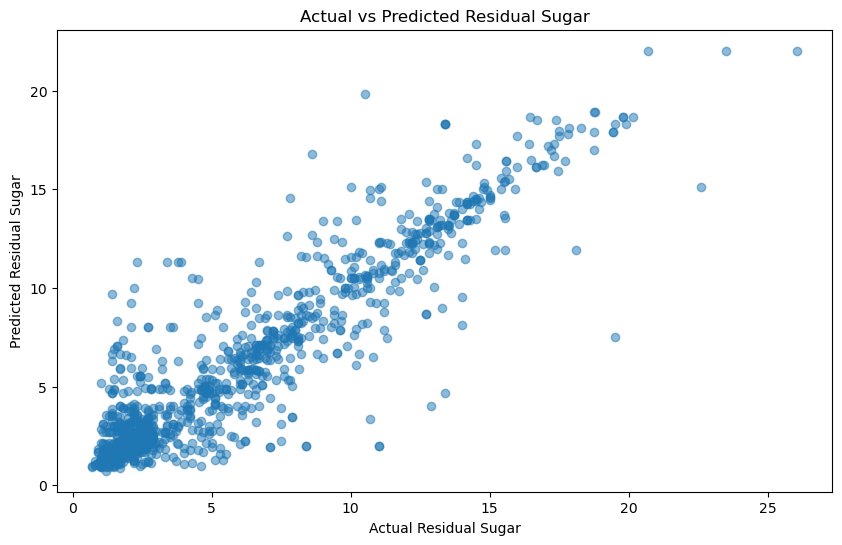

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Re-split the data using the preserved indices
X_residual_sugar = wine_data.drop(columns=['residual_sugar'])
y_residual_sugar = wine_data['residual_sugar']

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_residual_sugar, y_residual_sugar, test_size=0.2, random_state=42)

# Define the parameter grid for DecisionTreeRegressor
param_grid_rs = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeRegressor
decision_tree_reg_cv = DecisionTreeRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search_rs = GridSearchCV(decision_tree_reg_cv, param_grid_rs, cv=5)
grid_search_rs.fit(X_train_rs, y_train_rs)

# Get the best estimator
best_decision_tree_reg = grid_search_rs.best_estimator_

# Prediction on train and test sets
train_rs_predictions = best_decision_tree_reg.predict(X_train_rs)
test_rs_predictions = best_decision_tree_reg.predict(X_test_rs)

# Calculate mean squared error
train_rs_error = mean_squared_error(y_train_rs, train_rs_predictions)
test_rs_error = mean_squared_error(y_test_rs, test_rs_predictions)

print("Mean Squared Error on train set (best decision tree regressor):", train_rs_error)
print("Mean Squared Error on test set (best decision tree regressor):", test_rs_error)

# Plot actual vs predicted residual sugar
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rs, test_rs_predictions, alpha=0.5)
plt.title('Actual vs Predicted Residual Sugar')
plt.xlabel('Actual Residual Sugar')
plt.ylabel('Predicted Residual Sugar')
plt.show()

## Question 7 *(Optional)*

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.

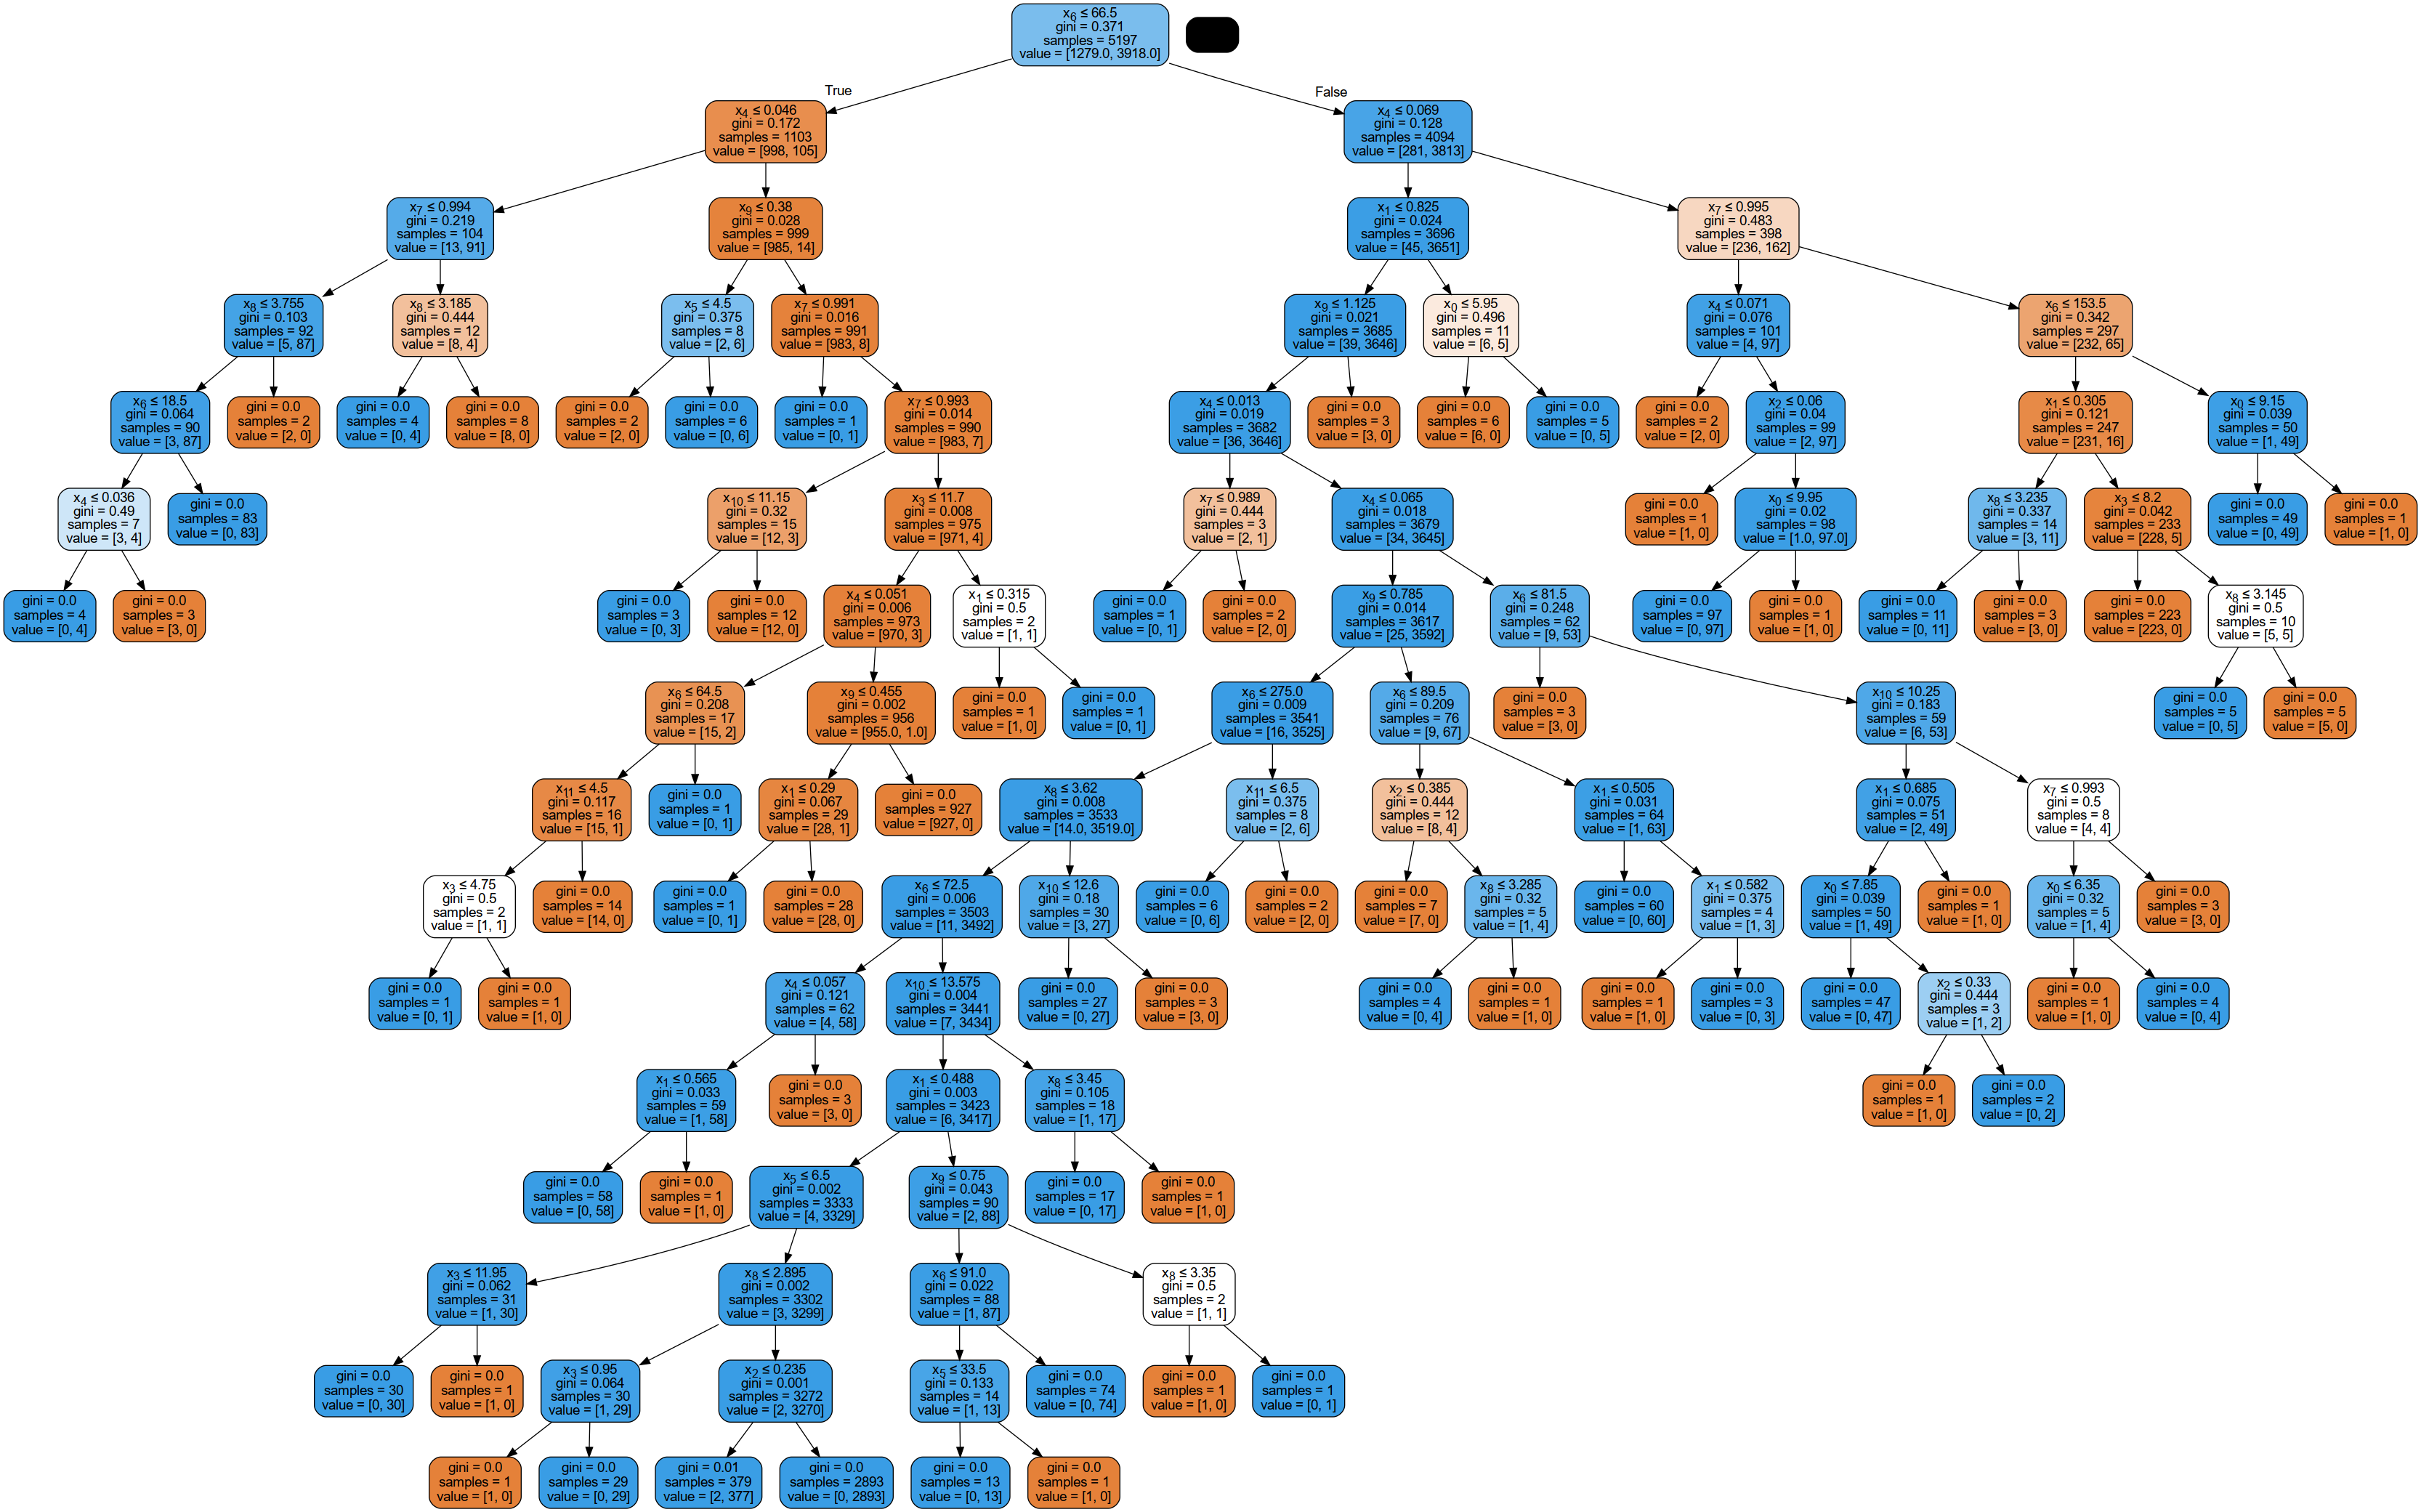

In [10]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

# Visualization of decision tree from question 3
dot_data = StringIO()
export_graphviz(tree_classifier, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Visualization of decision tree from question 4
dot_data_cv = StringIO()
export_graphviz(best_decision_tree, out_file=dot_data_cv, filled=True, rounded=True, special_characters=True)
graph_cv = pydotplus.graph_from_dot_data(dot_data_cv.getvalue())
Image(graph_cv.create_png())